#### Pre-processing

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
!pip install torchsummary
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install ptflops
# from ptflops import get_model_complexity_info
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [3]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_student = 1
num_classes = 10

# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(123)

In [4]:
# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/99H_datasets/MNIST_M.zip'
# Upload directly
# !unzip './MNIST_M.zip'

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_student_acc"], label="Train")
    ax1.plot(history["val_student_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_student_loss"], label="Train")
    ax2.plot(history["val_student_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

Streaming output truncated to the last 5000 lines.
 extracting: MNIST_M/train/9/00008555.png  
 extracting: MNIST_M/train/9/00008558.png  
 extracting: MNIST_M/train/9/00008563.png  
 extracting: MNIST_M/train/9/00008581.png  
 extracting: MNIST_M/train/9/00008585.png  
 extracting: MNIST_M/train/9/00008586.png  
 extracting: MNIST_M/train/9/00008592.png  
 extracting: MNIST_M/train/9/00008601.png  
 extracting: MNIST_M/train/9/00008608.png  
 extracting: MNIST_M/train/9/00008620.png  
 extracting: MNIST_M/train/9/00008626.png  
 extracting: MNIST_M/train/9/00008630.png  
 extracting: MNIST_M/train/9/00008641.png  
 extracting: MNIST_M/train/9/00008654.png  
 extracting: MNIST_M/train/9/00008669.png  
 extracting: MNIST_M/train/9/00008671.png  
 extracting: MNIST_M/train/9/00008674.png  
 extracting: MNIST_M/train/9/00008702.png  
 extracting: MNIST_M/train/9/00008714.png  
 extracting: MNIST_M/train/9/00008721.png  
 extracting: MNIST_M/train/9/00008736.png  
 extracting: MNIST_M/trai

#### Low-Rank Approximation
X. Jian, J.-Y. Li, and Y.-F. Gong. "Restructuring of Deep Neural Network Acoustic Models with Singular Value
Decomposition.", Interspeech, pp. 2365-2369, 2013.\
Ref: https://www.microsoft.com/en-us/research/wp-content/uploads/2013/01/svd_v2.pdf

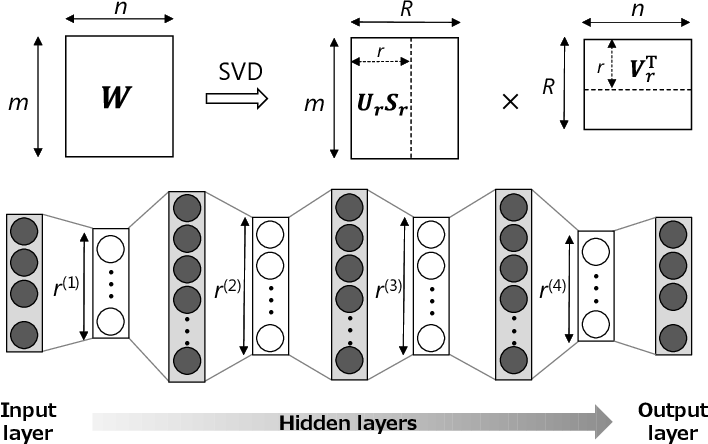

#### Visualization of Non-low-ranking vs low-ranking
Example: https://medium.com/@weidagang/data-compression-with-low-rank-approximation-using-neural-networks-d6a8e8426101


Original matrix shape: (100, 50)
Epoch 0: Loss = 26.0513
Epoch 100: Loss = 0.1495
Epoch 200: Loss = 0.1327
Epoch 300: Loss = 0.1282
Epoch 400: Loss = 0.1219
U_matrix shape: (100, 10)
V_matrix shape: (10, 50)
Loaded U_matrix shape: (100, 10)
Loaded V_matrix shape: (10, 50)
Compression Ratio: 3.33
Approximation Error (Frobenius Norm): 23.7630
Approximation Error (Avg Percent): 5.64%


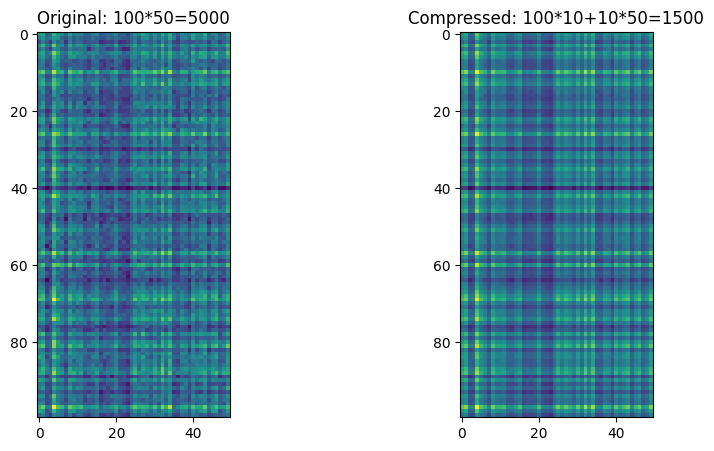

In [5]:
# --- Data Prepration ---
n = 100
m = 50
hidden_rank = 20 # hidden rank of the data
rank = 10  # Rank of approximation

# True low-rank structure (for demonstration)
U_true = np.random.rand(n, hidden_rank)
V_true = np.random.rand(hidden_rank, m)
original_matrix = U_true @ V_true + 0.1 * np.random.randn(n, m)
print(f'Original matrix shape: {original_matrix.shape}')

# The model input is an identity matrix, instead of the original matrix.
# So all the information about the expected output data can be compressed
# into the 2 low-rank matrices.
input = torch.from_numpy(np.eye(n)).float()

# Use the original matrix as the label.
label = torch.from_numpy(original_matrix).float()

# --- Defining the Model ---
class LowRankApprox(nn.Module):
    def __init__(self, n, m, rank):
        super().__init__()
        self.U = nn.Linear(n, rank, bias=False)
        self.V = nn.Linear(rank, m, bias=False)

    def forward(self, x):
        return self.V(self.U(x))

model = LowRankApprox(n, m, rank)
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# --- Training ---
epochs = 500
for epoch in range(epochs):
    output = model(input)
    loss = loss_fn(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item():.4f}')

# --- Saving Matrices ---
U_matrix = model.U.weight.detach().numpy().transpose()
V_matrix = model.V.weight.detach().numpy().transpose()
print(f'U_matrix shape: {U_matrix.shape}')
print(f'V_matrix shape: {V_matrix.shape}')
np.save('U_matrix.npy', U_matrix)
np.save('V_matrix.npy', V_matrix)


# --- Reloading Matrices ---
U_matrix = np.load('U_matrix.npy')
V_matrix = np.load('V_matrix.npy')
print(f'Loaded U_matrix shape: {U_matrix.shape}')
print(f'Loaded V_matrix shape: {V_matrix.shape}')
approximation = U_matrix @ V_matrix

# --- Evaluation ---
compression_ratio = (n * m)  / (n * rank + rank * m )
print(f'Compression Ratio: {compression_ratio:.2f}')

error = np.linalg.norm(original_matrix - approximation)
print(f'Approximation Error (Frobenius Norm): {error:.4f}')

abs_error = np.abs(original_matrix - approximation)
relative_error = abs_error / (np.abs(original_matrix) + 1e-8)
percent_error = 100 * np.mean(relative_error)
print(f'Approximation Error (Avg Percent): {percent_error:.2f}%')

# --- Visualization ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_matrix)
plt.title(f'Original: {n}*{m}={n*m}')

plt.subplot(1, 2, 2)
plt.imshow(approximation)
plt.title(f'Compressed: {n}*{rank}+{rank}*{m}={n*rank+rank*m}')
plt.show()

Ref: https://medium.com/@varagh2/low-rank-optimization-to-compress-a-model-6d7418e891ac

In [6]:
# Example of a generic low rank factorization for array samples

import numpy as np

# Create a user-item matrix (e.g., user ratings)
# This is a simple example; you should replace this with your data
user_item_matrix = np.array([
    [5, 4, 0, 1, 0],
    [4, 0, 3, 1, 0],
    [1, 0, 0, 5, 4],
    [0, 1, 5, 4, 5]
])

# Perform SVD factorization
U, Sigma, VT = np.linalg.svd(user_item_matrix, full_matrices=False)

# Specify the desired low rank (number of latent factors)
k = 2

# Reconstruct the matrix with a lower rank approximation
U_k = U[:, :k]
Sigma_k = np.diag(Sigma[:k])
VT_k = VT[:k, :]

user_item_matrix_approx = np.dot(U_k, np.dot(Sigma_k, VT_k))

# Now, user_item_matrix_approx contains the low-rank approximation of the original matrix
print("Original User-Item Matrix:")
print(user_item_matrix)
print("\nLow-Rank Approximation (k=2):")
print(user_item_matrix_approx)

Original User-Item Matrix:
[[5 4 0 1 0]
 [4 0 3 1 0]
 [1 0 0 5 4]
 [0 1 5 4 5]]

Low-Rank Approximation (k=2):
[[ 5.41568326  2.90021003  0.96027988  0.79937254 -0.42029949]
 [ 3.33507949  1.81162257  1.24419831  1.4210575   0.72236071]
 [ 0.52868834  0.37944563  2.54831089  3.57012382  3.64807301]
 [ 0.46425301  0.38309582  3.50922726  4.94395384  5.11445954]]


-----
#### Low-rank SVD into student model


In [7]:
# @title FLOPS computation
# Code from https://github.com/Eric-mingjie/rethinking-network-pruning/blob/master/imagenet/l1-norm-pruning/compute_flops.py
import numpy as np
import os

import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable


def print_model_param_nums(model=None):
    if model == None:
        model = torchvision.models.alexnet()
    total = sum([param.nelement() if param.requires_grad else 0 for param in model.parameters()])
    print('  + Number of params: %.4fM' % (total / 1e6))

def count_model_param_flops(model=None, input_res=224, multiply_adds=True):

    prods = {}
    def save_hook(name):
        def hook_per(self, input, output):
            prods[name] = np.prod(input[0].shape)
        return hook_per

    list_1=[]
    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))
    list_2={}
    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)


    list_conv=[]
    def conv_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * (self.in_channels / self.groups)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        # flops = (kernel_ops * (2 if multiply_adds else 1) + bias_ops) * output_channels * output_height * output_width * batch_size

        num_weight_params = (self.weight.data != 0).float().sum()
        flops = (num_weight_params * (2 if multiply_adds else 1) + bias_ops * output_channels) * output_height * output_width * batch_size

        list_conv.append(flops)

    list_linear=[]
    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn=[]
    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement() * 2)

    list_relu=[]
    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling=[]
    def pooling_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        kernel_ops = self.kernel_size * self.kernel_size
        bias_ops = 0
        params = 0
        flops = (kernel_ops + bias_ops) * output_channels * output_height * output_width * batch_size

        list_pooling.append(flops)

    list_upsample=[]

    # For bilinear upsample
    def upsample_hook(self, input, output):
        batch_size, input_channels, input_height, input_width = input[0].size()
        output_channels, output_height, output_width = output[0].size()

        flops = output_height * output_width * output_channels * batch_size * 12
        list_upsample.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv2d):
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm2d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(net, torch.nn.MaxPool2d) or isinstance(net, torch.nn.AvgPool2d):
                net.register_forward_hook(pooling_hook)
            if isinstance(net, torch.nn.Upsample):
                net.register_forward_hook(upsample_hook)
            return
        for c in childrens:
            foo(c)

    if model == None:
        model = torchvision.models.alexnet()
    foo(model)
    input = Variable(torch.rand(3,input_res,input_res).unsqueeze(0), requires_grad = True)
    out = model(input)


    total_flops = (sum(list_conv) + sum(list_linear) + sum(list_bn) + sum(list_relu) + sum(list_pooling) + sum(list_upsample))

    print('Number of FLOPs: %.6f GFLOPs (%.2f MFLOPs)' % (total_flops / 1e9, total_flops / 1e6))

    return total_flops

In [52]:
class VGG11(nn.Module):
    def __init__(self, n_C=1000, is_expand=None):
        super(VGG11, self).__init__()

        # Change the input channels to 3 for RGB images
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        # The rest of the layers remain the same
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )

        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
        self.fc3 = nn.Linear(4096, n_C)

    def forward(self, x):
        if is_expand is not None:
            x = x.expand(x.data.shape[0], is_expand[0], is_expand[1], is_expand[2])

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# Update these variables
channel_size = 3  # For RGB input
image_size = 224
num_classes = 10

# Create the model and test
is_expand = [channel_size, image_size, image_size]
student_fn = VGG11(n_C=num_classes, is_expand=is_expand).to('cpu')
print(student_fn)
summary(student_fn, input_size=(channel_size, image_size, image_size))

VGG11(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4)

In [53]:
# @title Low-ranking SVD into student Model

# Decompose a dense layer using SVD
def decompose_dense_layer(layer, rank):
    weights = layer.weight.data.numpy()
    biases = layer.bias.data.numpy()

    # SVD decomposition
    U, S, Vt = np.linalg.svd(weights, full_matrices=False)

    # Take the first 'rank' components
    U_approx = U[:, :rank]
    S_approx = np.sqrt(S[:rank])  # Taking square root of singular values
    Vt_approx = Vt[:rank, :]

    W1 = torch.tensor(U_approx, dtype=torch.float32)
    W2 = torch.tensor(np.dot(np.diag(S_approx), Vt_approx), dtype=torch.float32)

    print(f"W1 shape: {W1.shape}")
    print(f"W2 shape: {W2.shape}")

    return W1, W2, biases


# each layer processing corresponding to low-rank SVD into decompose student model
class DecomposeStudentModel(nn.Module):
    def __init__(self, n_C, rank, is_expand):
        super(DecomposeStudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)  # Adjust input channels here
        self.batchnorm2d_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()
        self.maxpool2d_1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.batchnorm2d_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()
        self.maxpool2d_2 = nn.MaxPool2d(2)

        self.num_cnn_features = 64 * 4 * 4  # Adjust based on your architecture

        # Decomposed dense layers
        self.linear_1 = nn.Linear(self.num_cnn_features, rank)
        self.relu_lin1 = nn.ReLU()

        self.linear_2 = nn.Linear(rank, 64)
        self.relu_lin2 = nn.ReLU()

        self.linear_3 = nn.Linear(64, n_C)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Adjust to remove unnecessary expand
        if x.dim() == 3:
            x = x.unsqueeze(0)

        x = self.maxpool2d_1(self.relu_1(self.batchnorm2d_1(self.conv1(x))))
        x = self.maxpool2d_2(self.relu_2(self.batchnorm2d_2(self.conv2(x))))

        # Flatten
        fc = x.view(-1, self.num_cnn_features)
        fc = self.relu_lin1(self.linear_1(fc))
        fc = self.relu_lin2(self.linear_2(fc))
        out = self.logsoftmax(self.linear_3(fc))
        return out


# Define the rank for decomposition from full-size layer weight
rank_linear_1 = 32
W1, W2, biases = decompose_dense_layer(student_fn.fc1, rank_linear_1)

# Create the model and test
is_expand = [3, 224, 224]

# decompose network
is_expand = [channel_size, image_size, image_size]
decompose_student_fn = DecomposeStudentModel(n_C=num_classes, rank=rank_linear_1, is_expand=is_expand).to(device)

# Set weights for the decomposed layers
decompose_student_fn.linear_1.weight.data = W1.to(device)
decompose_student_fn.linear_2.weight.data = W2.to(device)
decompose_student_fn.linear_2.bias.data = torch.tensor(biases, dtype=torch.float32).to(device)

print(decompose_student_fn)
###########################################
# --- summarize model
# summary(decompose_student_fn, input_size=(channel_size, image_size, image_size))
# --- In case summary API go bugged
num_params = sum(p.numel() for p in decompose_student_fn.parameters())
print(f"Number of parameters [decompose_student_fn]: {num_params}")
###########################################

W1 shape: torch.Size([4096, 32])
W2 shape: torch.Size([32, 25088])
DecomposeStudentModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (maxpool2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm2d_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (maxpool2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=32, bias=True)
  (relu_lin1): ReLU()
  (linear_2): Linear(in_features=32, out_features=64, bias=True)
  (relu_lin2): ReLU()
  (linear_3): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)
Number of parameters [decompose_student_fn]: 992554


In [54]:
count_model_param_flops(model=student_fn.to('cpu').eval(), input_res=224, multiply_adds=True)

Number of FLOPs: 15.231056 GFLOPs (15231.06 MFLOPs)


tensor(1.5231e+10)


#### The convolution forward pass with CP/Tucker Decomposition (High-Order SVD)

Ref: https://jacobgil.github.io/deeplearning/tensor-decompositions-deep-learning

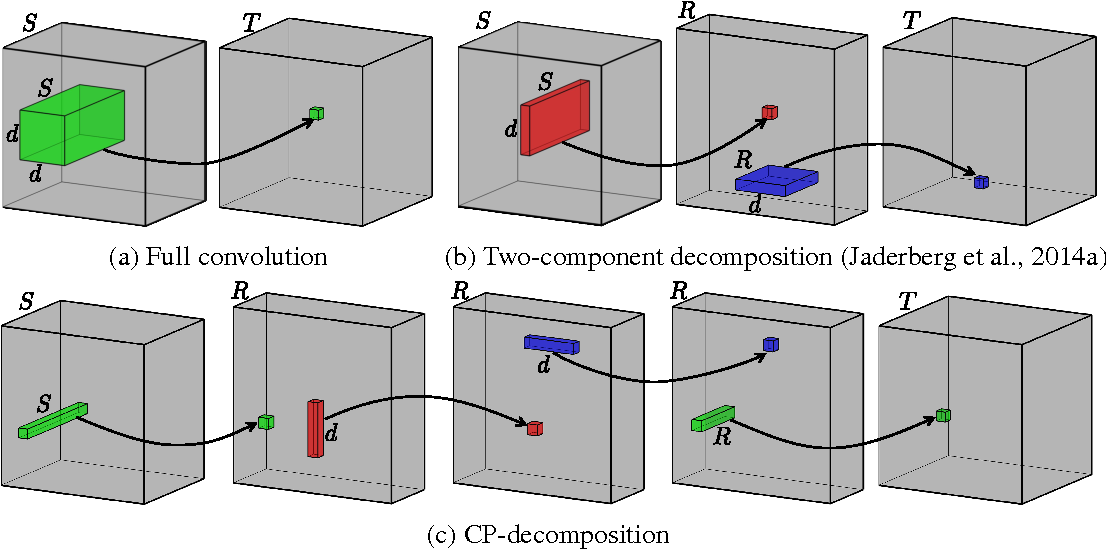

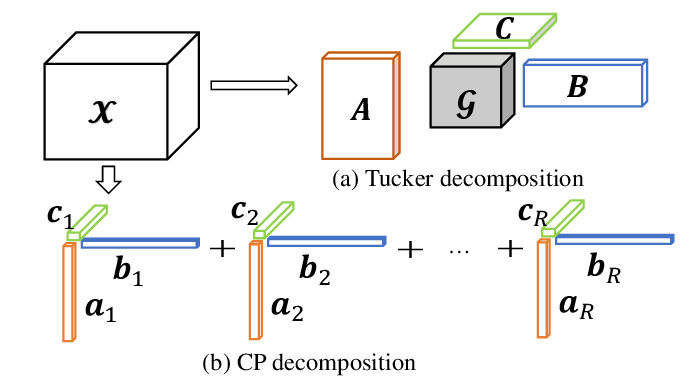

In [55]:
# @title Variational Bayes Matrix Factorization (VBMF) function
from __future__ import division

import numpy as np
from scipy.sparse.linalg import svds
from scipy.optimize import minimize_scalar

def VBMF(Y, cacb, sigma2=None, H=None):
    """Implementation of the analytical solution to Variational Bayes Matrix Factorization.

    This function can be used to calculate the analytical solution to VBMF.
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."

    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.
        To estimate cacb, use the function EVBMF().

    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.

    cacb : int
        Product of the prior variances of the matrices that factorize the input.

    sigma2 : int or None (default=None)
        Variance of the noise on Y.

    H : int or None (default = None)
        Maximum rank of the factorized matrices.

    Returns
    -------
    U : numpy-array
        Left-singular vectors.

    S : numpy-array
        Diagonal matrix of singular values.

    V : numpy-array
        Right-singular vectors.

    post : dictionary
        Dictionary containing the computed posterior values.


    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.

    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.
    """

    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L

    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None:
        upper_bound = (np.sum(s**2)+ residual)/(L+M)

        if L==H:
            lower_bound = s[-1]**2/M
        else:
            lower_bound = residual/((L-H)*M)

        sigma2_opt = minimize_scalar(VBsigma2, args=(L,M,cacb,s,residual), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x
        print("Estimated sigma2: ", sigma2)

    #Threshold gamma term
    #Formula above (21) from [1]
    thresh_term = (L+M + sigma2/cacb**2)/2
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))

    #Number of singular values where gamma>threshold
    pos = np.sum(s>threshold)

    #Formula (10) from [2]
    d = np.multiply(s[:pos],
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    #Computation of the posterior
    post = {}
    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post['ma'] = np.zeros(H)
    post['mb'] = np.zeros(H)
    post['sa2'] = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post['sb2'] = cacb * (1-M*zeta/sigma2) * np.ones(H)

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post['sa2']) + L*np.log(cacb/post['sb2'])
                        + (post['ma']**2 + M*post['sa2'])/cacb + (post['mb']**2 + L*post['sb2'])/cacb
                        + (-2 * np.multiply(np.multiply(post['ma'], post['mb']), s)
                           + np.multiply(post['ma']**2 + M*post['sa2'],post['mb']**2 + L*post['sb2']))/sigma2))

    return U[:,:pos], np.diag(d), V[:,:pos], post


def VBsigma2(sigma2,L,M,cacb,s,residual):
    H = len(s)

    thresh_term = (L+M + sigma2/cacb**2)/2
    threshold = np.sqrt( sigma2 * (thresh_term + np.sqrt(thresh_term**2 - L*M) ))
    pos = np.sum(s>threshold)

    d = np.multiply(s[:pos],
                    1 - np.multiply(sigma2/(2*s[:pos]**2),
                                    L+M+np.sqrt( (M-L)**2 + 4*s[:pos]**2/cacb**2 )))

    zeta = sigma2/(2*L*M) * (L+M+sigma2/cacb**2 - np.sqrt((L+M+sigma2/cacb**2)**2 - 4*L*M))
    post_ma = np.zeros(H)
    post_mb = np.zeros(H)
    post_sa2 = cacb * (1-L*zeta/sigma2) * np.ones(H)
    post_sb2 = cacb * (1-M*zeta/sigma2) * np.ones(H)

    delta = cacb/sigma2 * (s[:pos]-d- L*sigma2/s[:pos])
    post_ma[:pos] = np.sqrt(np.multiply(d, delta))
    post_mb[:pos] = np.sqrt(np.divide(d, delta))
    post_sa2[:pos] = np.divide(sigma2*delta, s[:pos])
    post_sb2[:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))

    F = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2 - (L+M)*H
               + np.sum(M*np.log(cacb/post_sa2) + L*np.log(cacb/post_sb2)
                        + (post_ma**2 + M*post_sa2)/cacb + (post_mb**2 + L*post_sb2)/cacb
                        + (-2 * np.multiply(np.multiply(post_ma, post_mb), s)
                           + np.multiply(post_ma**2 + M*post_sa2,post_mb**2 + L*post_sb2))/sigma2))
    return F



def EVBMF(Y, sigma2=None, H=None):
    """Implementation of the analytical solution to Empirical Variational Bayes Matrix Factorization.

    This function can be used to calculate the analytical solution to empirical VBMF.
    This is based on the paper and MatLab code by Nakajima et al.:
    "Global analytic solution of fully-observed variational Bayesian matrix factorization."

    Notes
    -----
        If sigma2 is unspecified, it is estimated by minimizing the free energy.
        If H is unspecified, it is set to the smallest of the sides of the input Y.

    Attributes
    ----------
    Y : numpy-array
        Input matrix that is to be factorized. Y has shape (L,M), where L<=M.

    sigma2 : int or None (default=None)
        Variance of the noise on Y.

    H : int or None (default = None)
        Maximum rank of the factorized matrices.

    Returns
    -------
    U : numpy-array
        Left-singular vectors.

    S : numpy-array
        Diagonal matrix of singular values.

    V : numpy-array
        Right-singular vectors.

    post : dictionary
        Dictionary containing the computed posterior values.


    References
    ----------
    .. [1] Nakajima, Shinichi, et al. "Global analytic solution of fully-observed variational Bayesian matrix factorization." Journal of Machine Learning Research 14.Jan (2013): 1-37.

    .. [2] Nakajima, Shinichi, et al. "Perfect dimensionality recovery by variational Bayesian PCA." Advances in Neural Information Processing Systems. 2012.
    """
    L,M = Y.shape #has to be L<=M

    if H is None:
        H = L

    alpha = L/M
    tauubar = 2.5129*np.sqrt(alpha)

    #SVD of the input matrix, max rank of H
    U,s,V = np.linalg.svd(Y)
    U = U[:,:H]
    s = s[:H]
    V = V[:H].T

    #Calculate residual
    residual = 0.
    if H<L:
        residual = np.sum(np.sum(Y**2)-np.sum(s**2))

    #Estimation of the variance when sigma2 is unspecified
    if sigma2 is None:
        xubar = (1+tauubar)*(1+alpha/tauubar)
        eH_ub = int(np.min([np.ceil(L/(1+alpha))-1, H]))-1
        upper_bound = (np.sum(s**2)+residual)/(L*M)
        lower_bound = np.max([s[eH_ub+1]**2/(M*xubar), np.mean(s[eH_ub+1:]**2)/M])

        scale = 1.#/lower_bound
        s = s*np.sqrt(scale)
        residual = residual*scale
        lower_bound = lower_bound*scale
        upper_bound = upper_bound*scale

        sigma2_opt = minimize_scalar(EVBsigma2, args=(L,M,s,residual,xubar), bounds=[lower_bound, upper_bound], method='Bounded')
        sigma2 = sigma2_opt.x

    #Threshold gamma term
    threshold = np.sqrt(M*sigma2*(1+tauubar)*(1+alpha/tauubar))
    pos = np.sum(s>threshold)

    #Formula (15) from [2]
    d = np.multiply(s[:pos]/2, 1-np.divide((L+M)*sigma2, s[:pos]**2) + np.sqrt((1-np.divide((L+M)*sigma2, s[:pos]**2))**2 -4*L*M*sigma2**2/s[:pos]**4) )

    #Computation of the posterior
    post = {}
    post['ma'] = np.zeros(H)
    post['mb'] = np.zeros(H)
    post['sa2'] = np.zeros(H)
    post['sb2'] = np.zeros(H)
    post['cacb'] = np.zeros(H)

    tau = np.multiply(d, s[:pos])/(M*sigma2)
    delta = np.multiply(np.sqrt(np.divide(M*d, L*s[:pos])), 1+alpha/tau)

    post['ma'][:pos] = np.sqrt(np.multiply(d, delta))
    post['mb'][:pos] = np.sqrt(np.divide(d, delta))
    post['sa2'][:pos] = np.divide(sigma2*delta, s[:pos])
    post['sb2'][:pos] = np.divide(sigma2, np.multiply(delta, s[:pos]))
    post['cacb'][:pos] = np.sqrt(np.multiply(d, s[:pos])/(L*M))
    post['sigma2'] = sigma2
    post['F'] = 0.5*(L*M*np.log(2*np.pi*sigma2) + (residual+np.sum(s**2))/sigma2
                     + np.sum(M*np.log(tau+1) + L*np.log(tau/alpha +1) - M*tau))

    return U[:,:pos], np.diag(d), V[:,:pos], post

def EVBsigma2(sigma2,L,M,s,residual,xubar):
    H = len(s)

    alpha = L/M
    x = s**2/(M*sigma2)

    z1 = x[x>xubar]
    z2 = x[x<=xubar]
    tau_z1 = tau(z1, alpha)

    term1 = np.sum(z2 - np.log(z2))
    term2 = np.sum(z1 - tau_z1)
    term3 = np.sum( np.log( np.divide(tau_z1+1, z1)))
    term4 = alpha*np.sum(np.log(tau_z1/alpha+1))

    obj = term1+term2+term3+term4+ residual/(M*sigma2) + (L-H)*np.log(sigma2)

    return obj

def phi0(x):
    return x-np.log(x)

def phi1(x, alpha):
    return np.log(tau(x,alpha)+1) + alpha*np.log(tau(x,alpha)/alpha + 1) - tau(x,alpha)

def tau(x, alpha):
    return 0.5 * (x-(1+alpha) + np.sqrt((x-(1+alpha))**2 - 4*alpha))

In [58]:
# @title CP & Tucker decomposition
"""
  Ref: https://github.com/K0EKJE/CNN_compression_with_Tensor_Decomposition/blob/main/tensor_decomp/decompositions.py
"""

!pip install tensorly
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorly as tl
from tensorly.decomposition import partial_tucker, parafac

#--- CP
def cp_decomposition_conv_layer(layer, rank, res=False):
    """
    Perform CP decomposition on a convolutional layer's weight tensor.

    Args:
        layer: The input convolutional layer.
        rank (int): The target rank for the decomposition.
        res (bool): Whether to use a residual connection.

    Returns:
        Tuple[float, nn.Module]: A tuple containing the compression ratio and the
        decomposed convolutional layer(s) as an nn.Sequential object.

    This function performs CP decomposition on the weight tensor of a convolutional
    layer and returns the decomposed layers. It also optionally includes a residual
    connection if 'res' is True.
    """
    # Perform CP decomposition on the layer's weight tensor using tensorly
    l, f, v, h = parafac(np.asarray(layer.weight.data), rank=rank)[1]
    l, f, v, h = torch.tensor(l), torch.tensor(f), torch.tensor(v), torch.tensor(h)
    # Calculate the approximation ratio
    appro = tl.cp_to_tensor(parafac(np.asarray(layer.weight.data), rank=rank))
    ratio = tl.norm(appro) / tl.norm(np.asarray(layer.weight.data))

    # Create pointwise convolution layer to reduce spatial dimensions
    pointwise_s_to_r_layer = torch.nn.Conv2d(
        in_channels=f.shape[0],
        out_channels=f.shape[1],
        kernel_size=1,
        stride=1,
        padding=0,
        dilation=layer.dilation,
        bias=False)

    # Create depthwise vertical convolution layer
    depthwise_vertical_layer = torch.nn.Conv2d(
        in_channels=v.shape[1],
        out_channels=v.shape[1],
        kernel_size=(v.shape[0], 1),
        stride=1,
        padding=(layer.padding[0], 0),
        dilation=layer.dilation,
        groups=v.shape[1],
        bias=False)

    # Create depthwise horizontal convolution layer
    depthwise_horizontal_layer = torch.nn.Conv2d(
        in_channels=h.shape[1],
        out_channels=h.shape[1],
        kernel_size=(1, h.shape[0]),
        stride=layer.stride,
        padding=(0, layer.padding[0]),
        dilation=layer.dilation,
        groups=h.shape[1],
        bias=False)

    # Create pointwise convolution layer to expand spatial dimensions
    pointwise_r_to_t_layer = torch.nn.Conv2d(
        in_channels=l.shape[1],
        out_channels=l.shape[0],
        kernel_size=1,
        stride=1,
        padding=0,
        dilation=layer.dilation,
        bias=True)

    # Copy bias data from the original layer to the pointwise_r_to_t_layer
    pointwise_r_to_t_layer.bias.data = layer.bias.data

    # Set weights for each decomposed layer
    depthwise_horizontal_layer.weight.data = torch.transpose(h, 1, 0).unsqueeze(1).unsqueeze(1)
    depthwise_vertical_layer.weight.data = torch.transpose(v, 1, 0).unsqueeze(1).unsqueeze(-1)
    pointwise_s_to_r_layer.weight.data = torch.transpose(f, 1, 0).unsqueeze(-1).unsqueeze(-1)
    pointwise_r_to_t_layer.weight.data = l.unsqueeze(-1).unsqueeze(-1)

    # Create a list of the new layers
    new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer,
                  depthwise_horizontal_layer, pointwise_r_to_t_layer]

    if res:
        # Include a residual connection (ResNet) if 'res' is True
        return ratio, ResidualAdd(nn.Sequential(*new_layers), shortcut=nn.Conv2d(f.shape[0], l.shape[0], kernel_size=1))
    else:
        return ratio, nn.Sequential(*new_layers)
#---Tucker
def estimate_ranks(layer, method, threshold):
    """
    Estimate the ranks of unfolded matrices using VBMF or SVD.

    Args:
        layer: The layer whose weights will be used for rank estimation.
        method (str): The method to use for rank estimation ('VBMF' or 'SVD').
        threshold (float): The threshold value for SVD-based rank estimation.

    Returns:
        List[int]: A list containing the estimated ranks for each unfolded matrix.

    This function unfolds the weight tensor of a layer along its modes and estimates
    the ranks of the unfolded matrices using either VBMF or SVT methods.
    """
    weights = layer.weight.data

    # Unfold the weight tensor along mode 0 and mode 1
    unfold_0 = tl.base.unfold(np.asarray(weights), 0)
    unfold_1 = tl.base.unfold(np.asarray(weights), 1)

    ranks = []

    if method == 'VBMF':
        # Estimate ranks using VBMF (Variational Bayesian Matrix Factorization)
        _, diag_0, _, _ = EVBMF(unfold_0)
        _, diag_1, _, _ = EVBMF(unfold_1)
        ranks = [diag_0.shape[0], diag_1.shape[1]]

    elif method == 'SVD':
        # Estimate ranks using SVT (Singular Value Thresholding)
        U, S, V = torch.svd(torch.tensor(unfold_0))
        U1, S1, V1 = torch.svd(torch.tensor(unfold_1))
        rank0 = (S > threshold).sum().item()
        rank1 = (S1 > threshold).sum().item()
        ranks = [rank0, rank1]

    return ranks

def estimate_threshold(layer):
    """
    Estimate the singular values of unfolded matrices using SVD.

    Args:
        layer: The layer whose weights will be used for singular value estimation.

    Returns:
        torch.Tensor: The singular values of the unfolded matrices.

    This function unfolds the weight tensor of a layer along its modes and estimates
    the singular values of the unfolded matrices using Singular Value Decomposition
    for the first mode.
    """
    weights = layer.weight.data

    # Unfold the weight tensor along mode 0 and mode 1
    unfold_0 = tl.base.unfold(np.asarray(weights), 0)
    unfold_1 = tl.base.unfold(np.asarray(weights), 1)

    # Compute SVD for unfolded matrices
    U, S, V = torch.svd(torch.tensor(unfold_0))
    U1, S1, V1 = torch.svd(torch.tensor(unfold_1))

    # Return the singular values
    return S

def tucker_decomposition_conv_layer(layer, method, target_ratio_):
    """
    Perform Tucker decomposition on a convolutional layer's weight tensor.

    Args:
        layer: The input convolutional layer.
        method (str): The method to use for Tucker decomposition ('SVD' or 'VBMF').
        target_ratio_ (float): The target compression ratio.

    Returns:
        Tuple[int, int, float, nn.Module]: A tuple containing the number of parameters
        before and after decomposition, the compression ratio, and the decomposed
        convolutional layer(s) as an nn.Sequential object.

    This function performs Tucker decomposition on the weight tensor of a convolutional
    layer and returns the decomposed layers along with compression-related information.
    """
    if method == 'SVD':
        ratio = 0
        target_ratio = target_ratio_

        # Estimate the singular values of the unfolded matrices
        S = estimate_threshold(layer)

        # Binary search for the optimal rank
        left, right = 0, len(S) - 1
        while left <= right:
            mid = (left + right) // 2

            ranks = estimate_ranks(layer, method, threshold=S[mid])

            # Perform Partial Tucker decomposition
            core, [last, first] = partial_tucker(np.asarray(layer.weight.data),
                                                 modes=[0, 1], rank=ranks, init='svd')[0]
            core, last, first = torch.tensor(core), torch.tensor(last), torch.tensor(first)  # Convert to PyTorch tensors

            # Compute the approximation ratio
            appro = tl.tucker_tensor.tucker_to_tensor(
                partial_tucker(np.asarray(layer.weight.data),
                               modes=[0, 1], rank=ranks, init='svd')[0])
            ratio = tl.norm(appro) / tl.norm(np.asarray(layer.weight.data))

            # Check if the achieved compression ratio is close to the target
            if abs(target_ratio - ratio) < 0.02:
                break
            elif ratio < target_ratio:
                left = mid + 1
            else:
                right = mid - 1
    else:
        # Rank selection with VBMF
        ranks = estimate_ranks(layer, method, threshold=0.8)

       # Ensure ranks are not zero to avoid the reshape error
        ranks = [max(rank, 1) for rank in ranks]  # Force ranks to be at least 1

        core, [last, first] = partial_tucker(np.asarray(layer.weight.data),
                                             modes=[0, 1], rank=ranks, init='svd')[0]
        core, last, first = torch.tensor(core), torch.tensor(last), torch.tensor(first)

        appro = tl.tucker_tensor.tucker_to_tensor(
            partial_tucker(np.asarray(layer.weight.data),
                           modes=[0, 1], rank=ranks, init='svd')[0])
        ratio = tl.norm(appro) / tl.norm(np.asarray(layer.weight.data))

    print(method + " Estimated ranks: ", ranks)

    # A pointwise convolution that reduces the channels from S to R3
    first_layer = torch.nn.Conv2d(in_channels=first.shape[0],
                                  out_channels=first.shape[1], kernel_size=1,
                                  stride=1, padding=0, dilation=layer.dilation, bias=False)

    # A regular 2D convolution layer with R3 input channels
    # and R3 output channels
    core_layer = torch.nn.Conv2d(in_channels=core.shape[1],
                                 out_channels=core.shape[0], kernel_size=layer.kernel_size,
                                 stride=layer.stride, padding=layer.padding, dilation=layer.dilation,
                                 bias=False)

    # A pointwise convolution that increases the channels from R4 to T
    last_layer = torch.nn.Conv2d(in_channels=last.shape[1],
                                 out_channels=last.shape[0], kernel_size=1, stride=1,
                                 padding=0, dilation=layer.dilation, bias=True)

    # last_layer.bias.data = layer.bias.data

    first_layer.weight.data = torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)
    core_layer.weight.data = core

    # num_param, num_param_decomp = get_param(first.shape[0], last.shape[0], ranks)

    new_layers = [first_layer, core_layer, last_layer]
    return ratio, nn.Sequential(*new_layers)  #num_param, num_param_decomp,
#---








import copy
_decomp_student_fn = copy.deepcopy(student_fn)
_decomp_student_fn = _decomp_student_fn.to(device)
print(_decomp_student_fn._modules.keys())
N = len(_decomp_student_fn._modules.keys()); print(f'len of modules: {N}')

# vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
decomp = 'Tucker'
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
for i, key in enumerate(_decomp_student_fn._modules.keys()):
    if i >= N - 2:
        break
    # if isinstance(_decomp_student_fn._modules[key], torch.nn.modules.conv.Conv2d):
    if key in {'conv1', 'conv2'}:
        conv_layer = _decomp_student_fn._modules[key]
        if decomp=='CP':
          #---cp decomp
          rank = max(conv_layer.weight.data.numpy().shape)//3
          print("CP rank = "+ str(rank))
          ratio, decomposed = cp_decomposition_conv_layer(conv_layer, rank, res=False)
        elif decomp=='Tucker':
          #---tucker decomp
          # rank = max(conv_layer.weight.data.numpy().shape)//3
          print("Tucker rank = "+ str(rank))
          ratio, decomposed = tucker_decomposition_conv_layer(conv_layer, 'VBMF', target_ratio_=0.9) #nparam, npd,
          # count+=nparam
          # count_d+=npd
          # print("Number of params before: "+str(nparam)+" || after: "+str(npd))

        _decomp_student_fn._modules[key] = decomposed
        print("Decomposition of layer "+str(i)+" Completed. Ratio = " + str(ratio))






# is_expand = [channel_size, image_size, image_size]
# _decomp_student_fn = student_fn(n_C=10, rank=16, is_expand=is_expand).to(device)
print(_decomp_student_fn)
###########################################
# --- summarize model
summary(_decomp_student_fn, input_size=(channel_size, image_size, image_size))
# --- In case summary API go bugged
# num_params = sum(p.numel() for p in _decomp_student_fn.parameters())
# print(f"Number of parameters [_decomp_student_fn]: {num_params}")
###########################################
# Replace with the appropriate function to count parameters and FLOPs
count_model_param_flops(model=_decomp_student_fn.to('cpu').eval(), input_res=224, multiply_adds=True)

odict_keys(['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2', 'fc3'])
len of modules: 8
VGG11(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): C

tensor(1.5231e+10)

# Summary
Low-rank approximation is a technique used in model compression to reduce the size and complexity of machine learning models while preserving their performance. The key idea is to approximate a large, high-dimensional matrix (which represents model parameters) with a product of smaller, low-rank matrices. Here's a summary of how it works:

Matrix Representation: Machine learning models, especially neural networks, often use large weight matrices. These matrices can be decomposed into lower-dimensional structures.

Low-Rank Decomposition: The weight matrix is approximated by the product of two or more smaller matrices. For example, a weight matrix 𝑊 can be approximated by 𝑊≈𝐴𝐵, where 𝐴 and 𝐵 are smaller matrices.

Benefits: This decomposition reduces the number of parameters in the model, which decreases memory usage and computational requirements. It also helps in reducing overfitting by simplifying the model.

Techniques: Common methods for low-rank approximation include Singular Value Decomposition (SVD), which decomposes a matrix into three other matrices, and various optimization techniques that learn the low-rank approximation directly during training.

Trade-offs: While low-rank approximation reduces computational costs and model size, it may introduce some loss in model accuracy. However, the goal is to balance compression and performance.

Overall, low-rank approximation is a powerful tool in model compression, making large models more efficient and easier to deploy without a significant sacrifice in their predictive capabilities.

# Homework
จงบีบอัด Normal SVD (SVD-1d)/CP decomposition (SVD-2d)/Mixed methods ใช้กับ VGG11 model ข้างใต้ ให้มีความเบากว่าและประสิทธิภาพลดเพียงเล้กน้อย (เท่าที่ทำได้) เช่น

*   ลดการใช้ parameters
*   ลดการใช้ resource (e.g., FLOPs)


```
# VGG implements the 11 weight layers NN from the VGG paper
# Ref: https://arxiv.org/pdf/1409.1556.pdf

class VGG11(nn.Module):
  def __init__(self, num_classes=1000):
    super(MNIST_VGG, self).__init__()

    # Initialize the modules we need to build the network
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.layer5 = nn.Sequential(
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    )

    self.fc1 = nn.Sequential(
      nn.Linear(in_features=512 * 7 * 7, out_features=4096),
      nn.ReLU(inplace=True),
    )
    self.fc2 = nn.Sequential(
      nn.Linear(in_features=4096, out_features=4096),
      nn.ReLU(inplace=True),
    )

    self.fc3 = nn.Sequential(
      nn.Linear(in_features=4096, out_features=num_classes),
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    # flatten to prepare for the fully connected layers
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return x
```


กำหนดให้สามารถทำ low-rank ทั้ง conv2d/conv1d ทุกรูปแบบ

จัดทำโมเดล capture ส่งเป็น PDF